# Main housing construction period

In [1]:
from pynsee.download import get_file_list, get_column_metadata, download_file
from pynsee.geodata import get_geodata, get_geodata_list
from pynsee.geodata import GeoFrDataFrame

import py7zr
import tempfile
import os
import re
import shutil
import math
import urllib.request as request
from contextlib import closing
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [3]:
meta = get_file_list()
metacol = get_column_metadata("RP_LOGEMENT_2016")

pynsee.download's metadata rely on volunteering contributors and their manual updates. get_file_list does not provide data from official Insee's metadata API
Consequently, please report any issue
Column-specific metadata has been found for this file


In [4]:
meta_achl = metacol[metacol["column"] == "ACHL"].reset_index(drop=True)
meta_achl.loc[~meta_achl["value"].isin(["A11", "A12", "B11", "B12", "C100"]), "value"] = ">2005"
meta_achl.loc[meta_achl["value"] == ">2005", "value_label_fr"] = "Après 2005"
meta_achl = meta_achl[["value", "value_label_fr"]].drop_duplicates()
meta_achl.columns = ["ACHL", "ACHL_label_fr"]
meta_achl

,ACHL,ACHL_label_fr
0,A11,Avant 1919
1,A12,De 1919 à 1945
2,B11,De 1946 à 1970
3,B12,De 1971 à 1990
4,C100,De 1991 à 2005
5,>2005,Après 2005


In [5]:
df = download_file("RP_LOGEMENT_2017", variables = ["COMMUNE", "IRIS", "ACHL", "IPONDL"])
DF = df[["COMMUNE", "IRIS", "ACHL", "IPONDL"]].reset_index(drop=True)
DF["IPONDL"] = pd.to_numeric(DF["IPONDL"])
DF = DF.groupby(["COMMUNE", "IRIS", "ACHL"], as_index=False).IPONDL.agg("sum")

Downloading: 100%|██████████| 373M/373M [00:49<00:00, 7.88MiB/s] 
Extracting: 100%|██████████| 4.42G/4.42G [00:49<00:00, 95.3MB/s]


Data saved:
/home/onyxia/.cache/pynsee/pynsee/4748274eba51ad29ca3d426ca5bb1ba3.parquet


In [6]:
pondTot = DF.groupby(["COMMUNE", "IRIS"], as_index=False)['IPONDL'].agg('sum')
pondTot = pondTot.rename(columns={'IPONDL': 'pondTot'})
DF = DF.merge(pondTot, on = ["COMMUNE", "IRIS"], how='left')

In [7]:
DF["pct"] = DF["IPONDL"] / DF["pondTot"] * 100
DF.loc[~DF["ACHL"].isin(["A11", "A12", "B11", "B12", "C100"]), "ACHL"] = ">2005"
data = DF.groupby(["COMMUNE", "IRIS", "ACHL"], as_index=False).pct.agg("sum")
data = data.merge(meta_achl, on = "ACHL", how="left")
data.loc[data["IRIS"] == "ZZZZZZZZZ", "IRIS"] = "0000"
data["CODE_IRIS"] = data["IRIS"]
data.loc[data["IRIS"] == "0000", "CODE_IRIS"] = data.loc[data["IRIS"] == "0000", "COMMUNE"] + data.loc[data["IRIS"] == "0000", "IRIS"]

#data.head(10)

In [8]:
data.head(10)

,COMMUNE,IRIS,ACHL,pct,ACHL_label_fr,CODE_IRIS
0,01001,0000,>2005,7.141565,Après 2005,010010000
1,01001,0000,A11,28.765250,Avant 1919,010010000
2,01001,0000,A12,3.160147,De 1919 à 1945,010010000
3,01001,0000,B11,3.445027,De 1946 à 1970,010010000
4,01001,0000,B12,29.377355,De 1971 à 1990,010010000
5,01001,0000,C100,28.110656,De 1991 à 2005,010010000
6,01002,0000,>2005,9.469609,Après 2005,010020000
7,01002,0000,A11,62.087134,Avant 1919,010020000
8,01002,0000,A12,10.058386,De 1919 à 1945,010020000
9,01002,0000,B11,4.744642,De 1946 à 1970,010020000


In [9]:
import os
import shutil
from pathlib import Path
from urllib.request import Request, urlopen
from contextlib import closing

ign_iris_2022 = "https://data.geopf.fr/telechargement/download/CONTOURS-IRIS/CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01/CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01.7z"

def get_iris_data(url=ign_iris_2022, update=False):
    list_string_split = url.split("/")
    filename = list_string_split[-1]
    list_string_split_filename = filename.split(".")
    filename_clean = list_string_split_filename[0]
    
    home = Path.home()
    dataDir = os.path.join(home, filename_clean)
    if not os.path.exists(dataDir):
        os.mkdir(dataDir)

    file_iris = os.path.join(dataDir, "file_" + filename_clean)

    req = Request(
        url=url, 
        headers={'User-Agent': 'Mozilla/5.0'},
    )
        
    if not os.path.exists(file_iris) or update:
        with closing(urlopen(req)) as r:
            with open(file_iris, 'wb') as f:
                shutil.copyfileobj(r, f)

    with py7zr.SevenZipFile(file_iris, mode='r') as z:
            z.extractall(dataDir)

    list_file = []
    list_file_size = []

    for root, d_names, f_names in os.walk(dataDir):
        for f in f_names:
            filename = root + "/" + f
            if re.search("CONTOURS-IRIS.shp", filename):
                list_file += [filename]
                list_file_size += [os.path.getsize(filename)]
    
    list_shp_df = []
                
    for f in list_file:  
               
        shp = gpd.read_file(f)
        shp = shp.to_crs("EPSG:3857")
        list_shp_df += [shp]
        
    shpFinal = pd.concat(list_shp_df)

    return shpFinal


In [10]:
shapefile = get_iris_data(update=False)

Found credentials in environment variables.
Found credentials in environment variables.
Found credentials in environment variables.


ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


Found credentials in environment variables.
Found credentials in environment variables.
Found credentials in environment variables.
Found credentials in environment variables.


In [11]:
shp = shapefile.sort_values(by = ["INSEE_COM"]).reset_index(drop=True)
shp.loc[shp["IRIS"] == "0000", "IRIS"] = "ZZZZZZZZZ"
shp.rename(columns={'INSEE_COM':'COMMUNE'}, inplace=True)

In [12]:
data['pct_max'] = data.groupby(['COMMUNE', "IRIS"])['pct'].transform(max)
dataMax = data[data["pct"] == data["pct_max"]].reset_index(drop=True)

list_dep_extract = []
for i in dataMax.index:
    dep = dataMax["COMMUNE"].values[i][:3]    
    if not re.search("^97", dep):
        dep = dataMax["COMMUNE"].values[i][:2]          
    list_dep_extract += [dep]
    
dataMax["insee_dep"] = list_dep_extract

dataFinal = dataMax.merge(shp[["CODE_IRIS", "geometry", "NOM_COM"]], on=["CODE_IRIS"], how = "left")

/tmp/ipykernel_3245/3716288836.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data['pct_max'] = data.groupby(['COMMUNE', "IRIS"])['pct'].transform(max)


In [13]:
dataFinal["crsCoord"] = "EPSG:3857"
dataFinal = dataFinal.reset_index(drop=True)

In [14]:
# iris limit missing for the following iris 
dataFinal.loc[dataFinal["geometry"].isnull(), ['insee_dep', "COMMUNE", "NOM_COM","CODE_IRIS", "geometry", "pct"]]

,insee_dep,COMMUNE,NOM_COM,CODE_IRIS,geometry,pct
1168,02,02695,NaN,026950000,None,43.589744
6853,16,16010,NaN,160100000,None,58.387483
7180,16,16351,NaN,163510000,None,26.476162
8241,19,19092,NaN,190920000,None,62.324577
8678,21,21213,NaN,212130000,None,33.436533
9049,21,21507,NaN,215070000,None,35.000000
10034,24,24089,NaN,240890000,None,28.181818
10229,24,24314,NaN,243140000,None,39.521733
10668,25,25134,NaN,251340000,None,53.787879
11156,25,25628,NaN,256280000,None,29.390681


In [15]:
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

100%|██████████| 99/99 [00:20<00:00,  4.74it/s]


Data saved:
/home/onyxia/.cache/pynsee/pynsee/c47b07b32af225908273318d7754d7f0.parquet


In [16]:
list_com = dataFinal.loc[dataFinal["geometry"].isnull()].COMMUNE.unique()

for c in list_com:
    dc = dataFinal[dataFinal["COMMUNE"] == c].reset_index(drop=True)
    if len(dc.index) == 1:
        geo = com[com["insee_com"] == c]
        if len(geo.index) == 1:
            geo = geo.get_geom() 
            dataFinal.loc[(dataFinal["COMMUNE"] == c), "geometry"] = [geo]

In [17]:
dataFinal = dataFinal[~dataFinal.geometry.isnull()]
dataFinal = GeoFrDataFrame(dataFinal).translate()
dataFinal = dataFinal.zoom(["75","92", "93", "91", "77", "78", "95", "94"],
                          factor=1.5, startAngle = math.pi * (1 - 3 * 1/9))

976 is missing from insee_dep column !


In [18]:
dataFinal['ACHL_label_en'] = dataFinal['ACHL_label_fr'].astype(str)
dataFinal = dataFinal.replace({'ACHL_label_en': {"Après": "After", "Avant" : "Before", "De" : "From", "à" : "to"}}, regex=True)
list_ranges_ACHL_label_en = ['Before 1919', 'From 1919 to 1945', 'From 1946 to 1970', 'From 1971 to 1990','From 1991 to 2005', 'After 2005']
dataFinal['ACHL_label_en'] = dataFinal['ACHL_label_en'].astype(CategoricalDtype(categories=list_ranges_ACHL_label_en, ordered=True))


In [19]:
dataFinal.head(3)

,COMMUNE,IRIS,ACHL,pct,ACHL_label_fr,CODE_IRIS,pct_max,insee_dep,geometry,NOM_COM,crsCoord,ACHL_label_en
0,97101,971010101,B12,40.872978,De 1971 à 1990,971010101,40.872978,971,MULTIPOLYGON (((-706086.0658401633 6311115.277...,Les Abymes,EPSG:3857,From 1971 to 1990
1,97101,971010102,B12,44.975760,De 1971 à 1990,971010102,44.975760,971,POLYGON ((-707141.4767627036 6308691.888286703...,Les Abymes,EPSG:3857,From 1971 to 1990
2,97101,971010103,C100,27.177460,De 1991 à 2005,971010103,27.177460,971,POLYGON ((-707141.4767627036 6308691.888286703...,Les Abymes,EPSG:3857,From 1991 to 2005


In [20]:
mapplot = gpd.GeoDataFrame(dataFinal, crs='EPSG:3857')

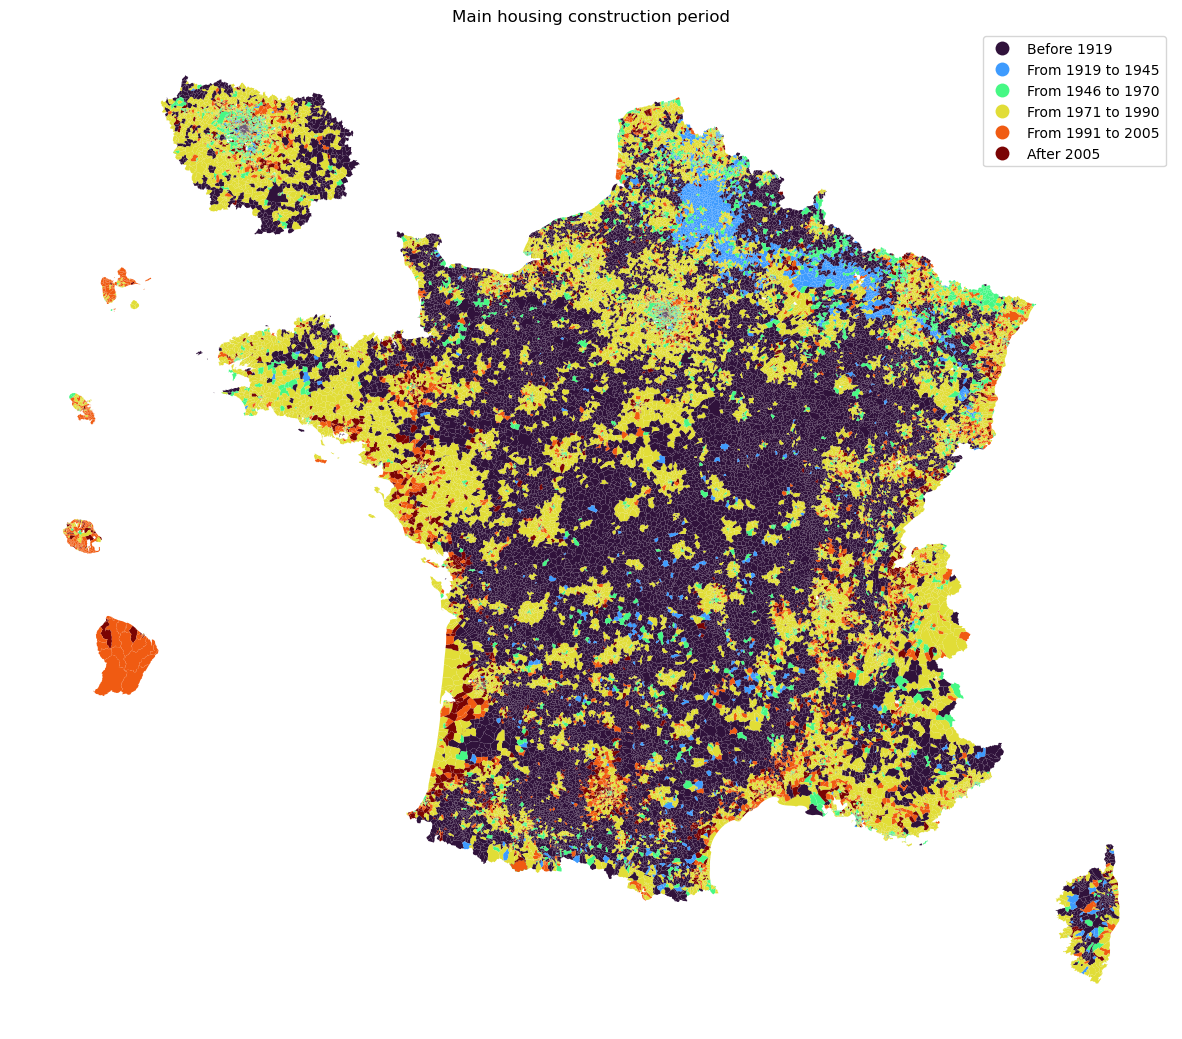

In [21]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
mapplot.plot(column='ACHL_label_en', cmap=cm.turbo,
    legend=True, ax=ax)
ax.set_axis_off()
ax.set(title='Main housing construction period')
plt.show()